/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_43587/2768922998.py:78: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_43587/2768922998.py:79: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) Arial.
  plt.savefig('max_residuals_by_parameter.png', dpi=300, bbox_inches='tight')
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


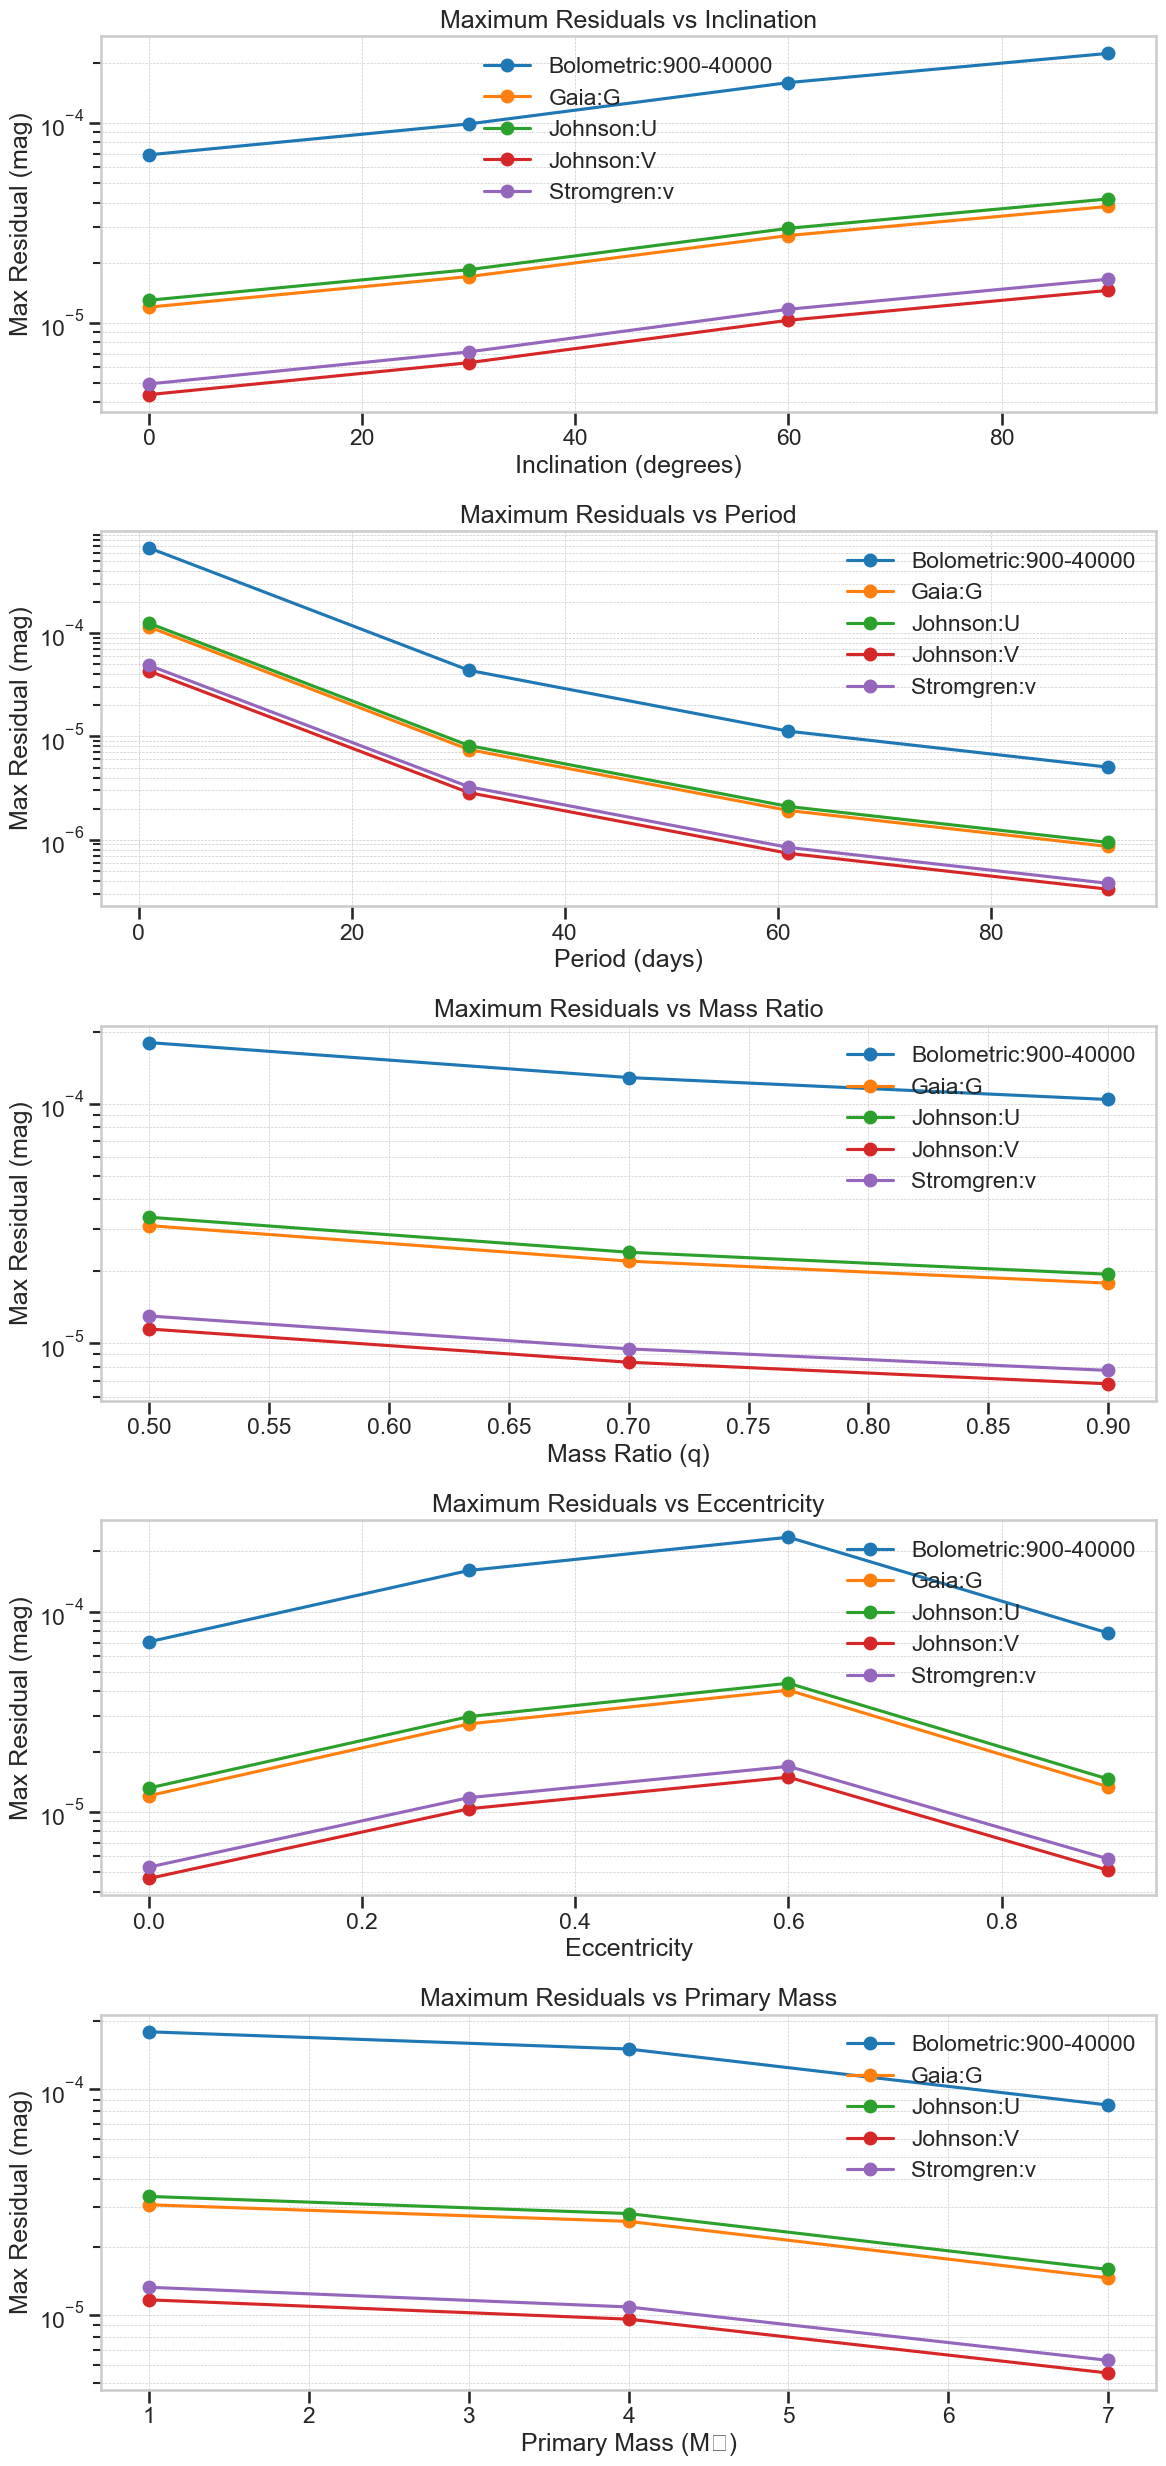

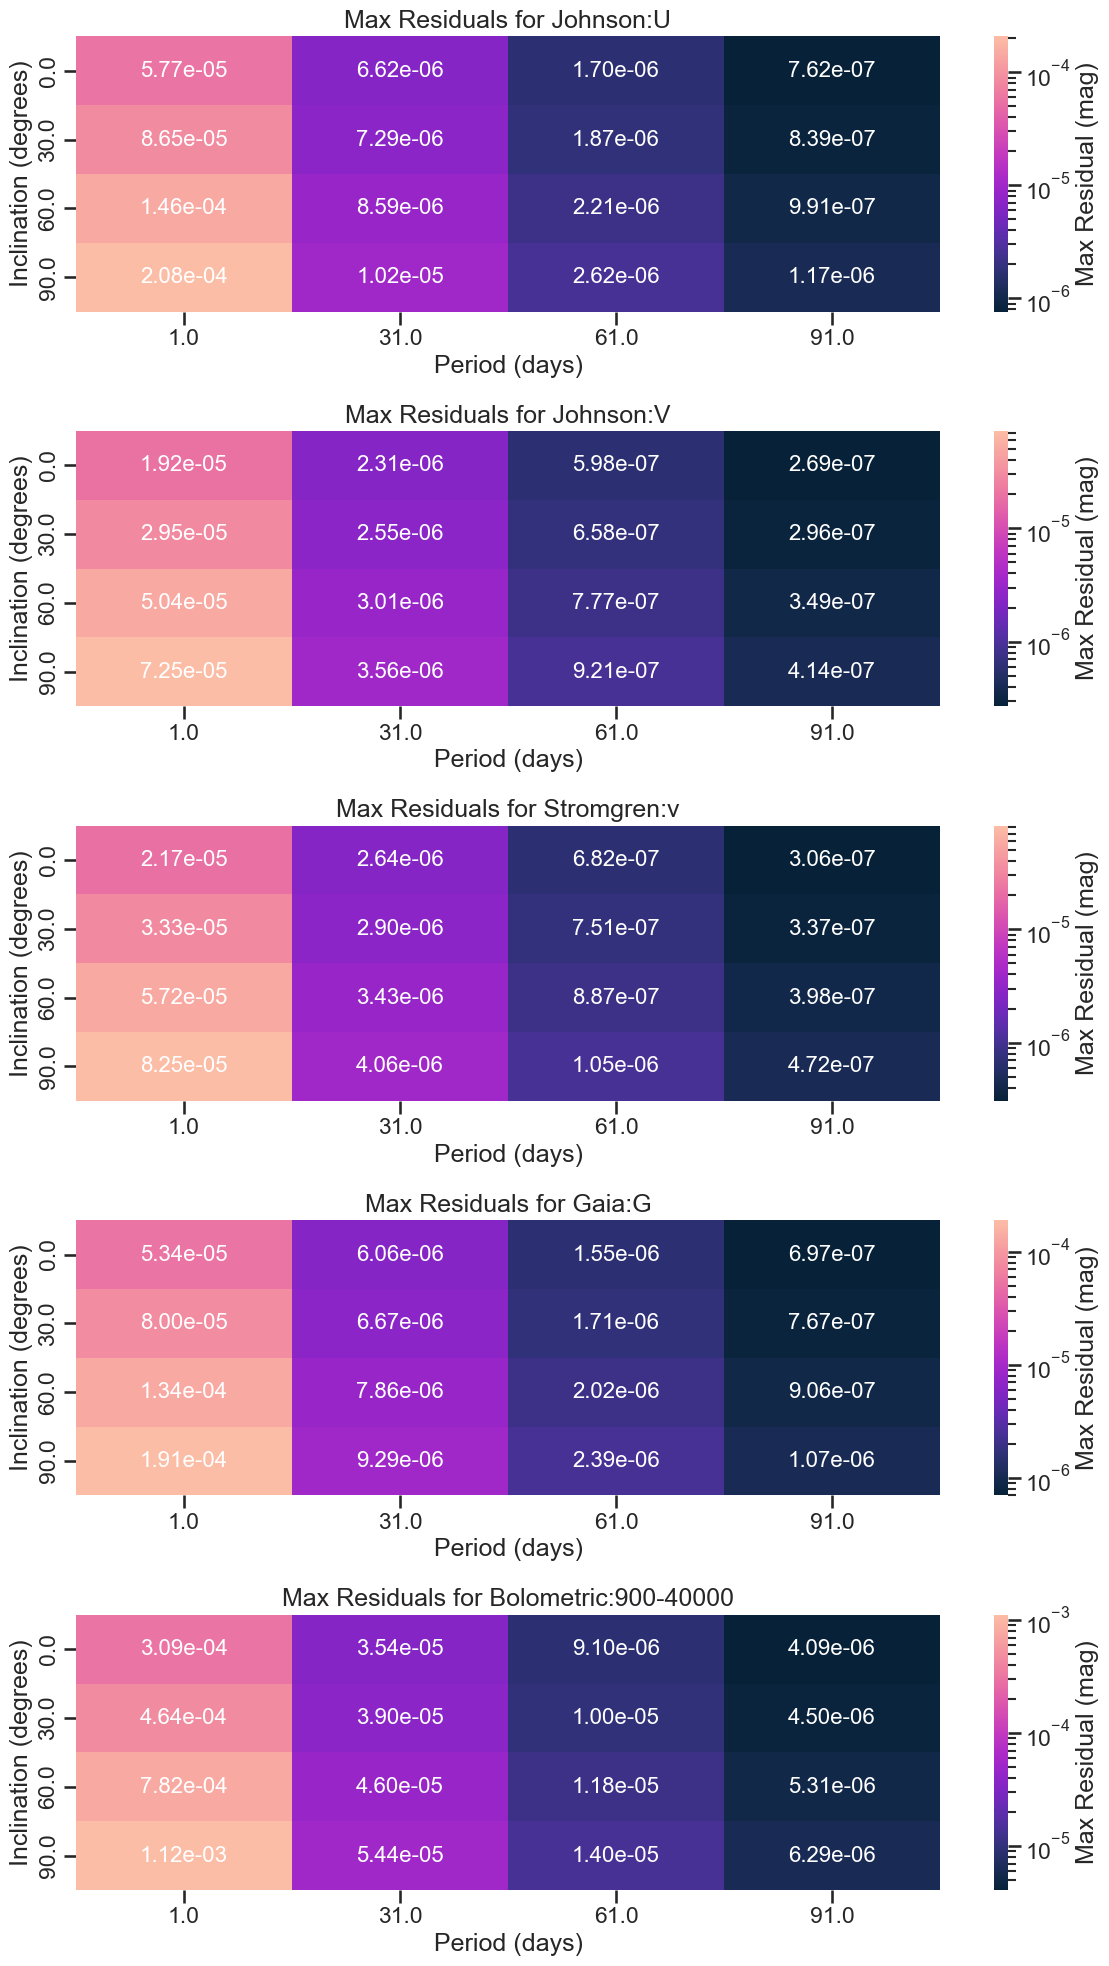

Summary of maximum residuals by filter:
                          mean       std  min       max
Filter                                                 
Bolometric:900-40000  0.000138  0.000399  0.0  0.003332
Gaia:G                0.000024  0.000069  0.0  0.000571
Johnson:U             0.000026  0.000074  0.0  0.000622
Johnson:V             0.000009  0.000026  0.0  0.000216
Stromgren:v           0.000010  0.000029  0.0  0.000246

Top 10 parameter combinations with largest residuals:
                    Filter  Inclination  Period  Mass Ratio  Eccentricity  \
2084  Bolometric:900-40000         90.0     1.0         0.5           0.3   
1764  Bolometric:900-40000         90.0     1.0         0.5           0.6   
2509  Bolometric:900-40000         60.0     1.0         0.5           0.6   
1069  Bolometric:900-40000         90.0     1.0         0.7           0.3   
134   Bolometric:900-40000         90.0     1.0         0.7           0.6   
1649  Bolometric:900-40000         60.0     1.0    

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.colors import LogNorm
import cmasher as cmr

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Function to extract parameters from directory name
def extract_params(dirname):
    parts = dirname.split('_')
    incl = float(parts[1])
    period = float(parts[3])
    q = float(parts[5])
    ecc = float(parts[7])
    primary_mass = float(parts[10])
    return incl, period, q, ecc, primary_mass

# Find all result directories
result_dirs = glob.glob('results/incl_*')

# Collect all max residuals
all_data = []

for dir_path in result_dirs:
    csv_path = os.path.join(dir_path, 'max_residuals.csv')
    if os.path.exists(csv_path):
        # Extract parameters from directory name
        incl, period, q, ecc, primary_mass = extract_params(os.path.basename(dir_path))
        
        # Read the max residuals
        df = pd.read_csv(csv_path)
        
        # Add parameters to the dataframe
        for _, row in df.iterrows():
            all_data.append({
                'Filter': row['Filter'],
                'Max Residual': row['Max Residual'],
                'Inclination': incl,
                'Period': period,
                'Mass Ratio': q,
                'Eccentricity': ecc,
                'Primary Mass': primary_mass
            })

# Convert to DataFrame
results_df = pd.DataFrame(all_data)

# Create a figure with subplots for each parameter
fig, axes = plt.subplots(5, 1, figsize=(12, 25))
parameters = ['Inclination', 'Period', 'Mass Ratio', 'Eccentricity', 'Primary Mass']
param_labels = ['Inclination (degrees)', 'Period (days)', 'Mass Ratio (q)', 'Eccentricity', 'Primary Mass (M☉)']

for i, (param, label) in enumerate(zip(parameters, param_labels)):
    ax = axes[i]
    
    # Group by parameter and filter, then get the mean max residual
    grouped = results_df.groupby([param, 'Filter'])['Max Residual'].mean().reset_index()
    
    # Plot for each filter
    for filter_name in grouped['Filter'].unique():
        filter_data = grouped[grouped['Filter'] == filter_name]
        ax.plot(filter_data[param], filter_data['Max Residual'], 'o-', label=filter_name)
    
    ax.set_xlabel(label)
    ax.set_ylabel('Max Residual (mag)')
    ax.set_yscale('log')
    ax.set_title(f'Maximum Residuals vs {param}')
    # Create legend with white background
    legend = ax.legend(facecolor='white', edgecolor='black')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('max_residuals_by_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

# Create heatmaps for pairs of parameters
# We'll focus on inclination vs period for each filter
filters = results_df['Filter'].unique()

fig, axes = plt.subplots(len(filters), 1, figsize=(12, 4*len(filters)))
if len(filters) == 1:
    axes = [axes]

for i, filter_name in enumerate(filters):
    filter_data = results_df[results_df['Filter'] == filter_name]
    
    # Create pivot table for inclination vs period
    pivot = filter_data.pivot_table(
        index='Inclination', 
        columns='Period', 
        values='Max Residual',
        aggfunc='mean'
    )
    
    # Plot heatmap
    heatmap = sns.heatmap(pivot, cmap=cmr.bubblegum, norm=LogNorm(), ax=axes[i], cbar_kws={'label': 'Max Residual (mag)'})
    
    # Add annotations with scientific notation in white
    for j in range(len(pivot.index)):
        for k in range(len(pivot.columns)):
            if not pd.isna(pivot.iloc[j, k]):
                axes[i].text(k + 0.5, j + 0.5, f'{pivot.iloc[j, k]:.2e}',
                           ha="center", va="center", color="white", fontsize=16)
    
    axes[i].set_title(f'Max Residuals for {filter_name}')
    axes[i].set_xlabel('Period (days)')
    axes[i].set_ylabel('Inclination (degrees)')

plt.tight_layout()
plt.savefig('max_residuals_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("Summary of maximum residuals by filter:")
summary = results_df.groupby('Filter')['Max Residual'].agg(['mean', 'std', 'min', 'max'])
print(summary)

# Find the parameter combinations with the largest residuals
print("\nTop 10 parameter combinations with largest residuals:")
top_residuals = results_df.sort_values('Max Residual', ascending=False).head(10)
print(top_residuals[['Filter', 'Inclination', 'Period', 'Mass Ratio', 'Eccentricity', 'Primary Mass', 'Max Residual']])


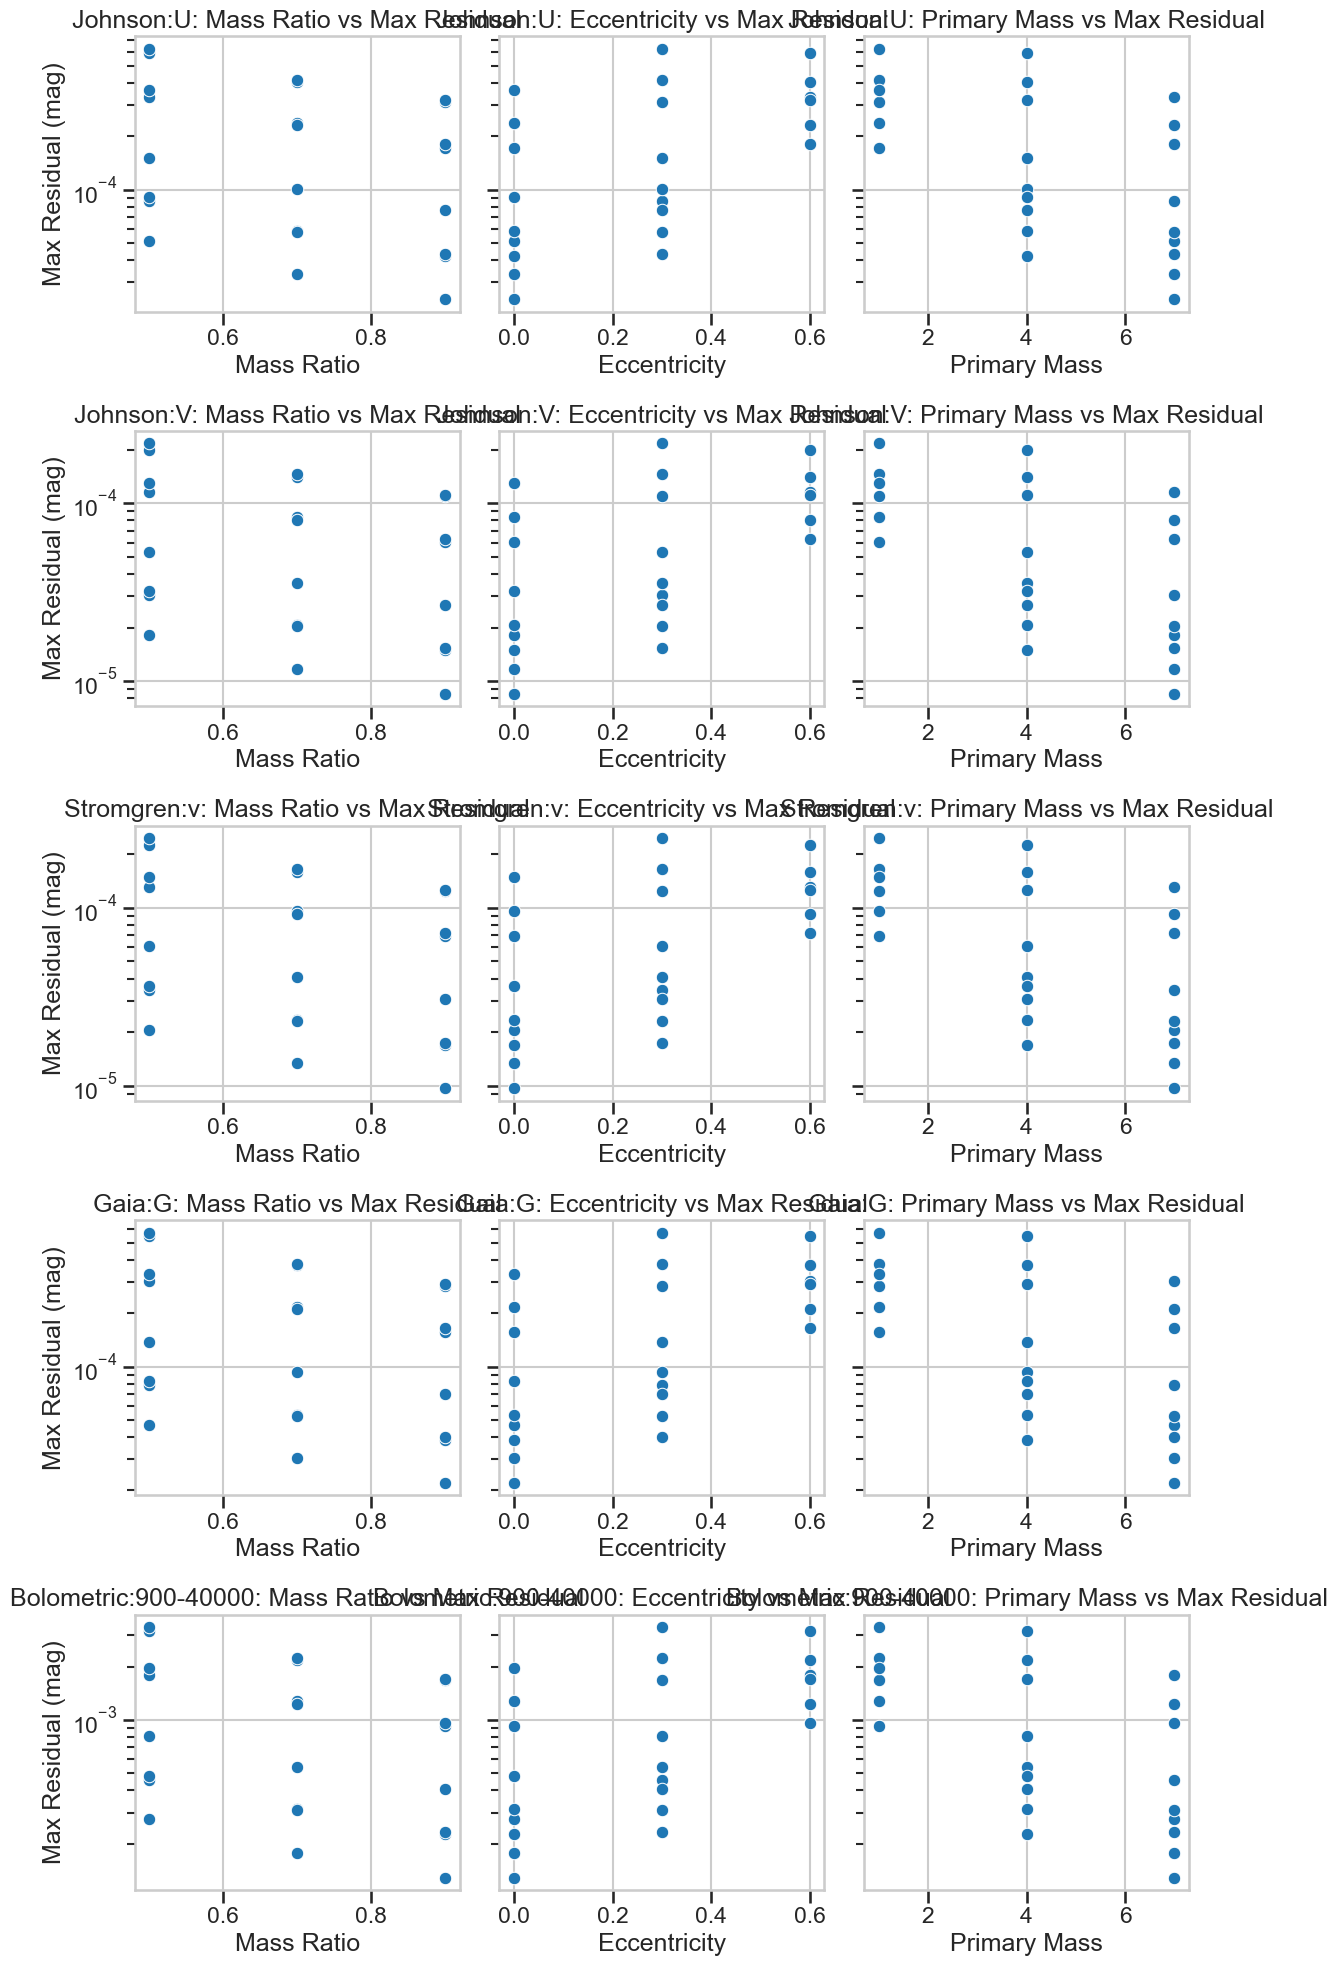


Summary for Inclination=90° and Period=1 day:
                   Filter  Mass Ratio  Eccentricity  Primary Mass  \
3    Bolometric:900-40000         0.5           0.3           1.0   
6    Bolometric:900-40000         0.5           0.6           4.0   
11   Bolometric:900-40000         0.7           0.3           1.0   
14   Bolometric:900-40000         0.7           0.6           4.0   
0    Bolometric:900-40000         0.5           0.0           1.0   
..                    ...         ...           ...           ...   
89              Johnson:V         0.9           0.0           4.0   
106           Stromgren:v         0.7           0.0           7.0   
82              Johnson:V         0.7           0.0           7.0   
114           Stromgren:v         0.9           0.0           7.0   
90              Johnson:V         0.9           0.0           7.0   

     Max Residual  
3        0.003332  
6        0.003161  
11       0.002221  
14       0.002180  
0        0.001962  
..  

In [2]:
# Filter data for inclination=90 and period=1
incl90_period1 = results_df[(results_df['Inclination'] == 90) & (results_df['Period'] == 1)]

if not incl90_period1.empty:
    # Create plots for other parameters
    other_params = ['Mass Ratio', 'Eccentricity', 'Primary Mass']
    
    fig, axes = plt.subplots(len(filters), len(other_params), figsize=(12, 4*len(filters)), sharey='row')
    
    # Handle case with single filter
    if len(filters) == 1:
        axes = [axes]
    
    for i, filter_name in enumerate(filters):
        filter_data = incl90_period1[incl90_period1['Filter'] == filter_name]
        
        for j, param in enumerate(other_params):
            ax = axes[i][j]
            
            # Create scatter plot
            sns.scatterplot(data=filter_data, x=param, y='Max Residual', ax=ax)
            
            ax.set_yscale('log')
            ax.set_title(f'{filter_name}: {param} vs Max Residual')
            ax.set_xlabel(param)
            
            if j == 0:
                ax.set_ylabel('Max Residual (mag)')
            else:
                ax.set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('incl90_period1_parameter_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a summary table for this specific case
    print("\nSummary for Inclination=90° and Period=1 day:")
    summary_90_1 = incl90_period1.groupby(['Filter', 'Mass Ratio', 'Eccentricity', 'Primary Mass'])['Max Residual'].mean().reset_index()
    summary_90_1 = summary_90_1.sort_values('Max Residual', ascending=False)
    print(summary_90_1)
else:
    print("No data available for inclination=90° and period=1 day")
